# **AGE and GENDER prediction using a pretrained VGG16**

---

## Import libraries


In [ ]:
import tarfile
from google.colab import drive
import shutil
import os

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.resnet_v2 import ResNet50V2 # modello resnet
from tensorflow.keras.applications import VGG16 # modello resnet

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
# Funzioni di ottimizzazione
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# salvataggio modelli e early_stopping regularization
from keras.callbacks import EarlyStopping, ModelCheckpoint




In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 98 kB 1.8 MB/s 


## Data loading

In [ ]:

# caricamento drive
drive.mount('/content/drive', force_remount=True)

# path principale delle cartella
drive_path = '/content/drive/MyDrive/Visual_Progetto_VGG/'




Mounted at /content/drive


In [ ]:
# carico il dataset sulla macchina locale e lo scompatto nella root
shutil.copyfile(drive_path + 'UTKFace.tar.gz', 'UTKFace.tar.gz')
tar = tarfile.open('UTKFace.tar.gz')
tar.extractall()
tar.close()
# cancello dalla root lo zip
os.remove('UTKFace.tar.gz')

In [ ]:
path = 'UTKFace/'

files = os.listdir(path)

print(f'Numero di immagini: ', len(files))

Numero di immagini:  23708


In [ ]:
# Creazione del dataframe a partire dalla lista di file

df = pd.DataFrame(columns=['img', 'gender_label', 'age_label']) 

for idx, f in enumerate(files):
  
  metadata = f.split('_')
  
  newrow = {'img': f, 'gender_label': metadata[1], 'age_label': int(metadata[0])}
  
  df = df.append(newrow, ignore_index = True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Rescaling dell'età

scaler = MinMaxScaler()

x = np.expand_dims(df['age_label'], -1)
scaler.fit(x)
new_x = scaler.transform(x)
df['age_label'] = new_x


# Per tornare indietro:
# scaler.inverse_transform(ages)
df

,img,gender_label,age_label
0,4_0_2_20170110212945664.jpg.chip.jpg,0,0.026087
1,4_1_4_20161221193328366.jpg.chip.jpg,1,0.026087
2,32_1_0_20170105163404036.jpg.chip.jpg,1,0.269565
3,1_0_0_20170110213203795.jpg.chip.jpg,0,0.000000
4,54_0_0_20170117191328833.jpg.chip.jpg,0,0.460870
...,...,...,...
23703,32_1_1_20170113000027033.jpg.chip.jpg,1,0.269565
23704,36_0_1_20170113142152196.jpg.chip.jpg,0,0.304348
23705,58_0_0_20170104185312638.jpg.chip.jpg,0,0.495652
23706,26_1_3_20170104235151882.jpg.chip.jpg,1,0.217391


In [ ]:
# Split in train set e test set

df = df.sample(frac=1, random_state=1234)
df = df.reset_index()

split_number = round(len(df)*0.8)

df_train = df.loc[:split_number]
df_test = df.loc[split_number+1:]


In [ ]:
df_train

,index,img,gender_label,age_label
0,2984,18_1_3_20170109214031495.jpg.chip.jpg,1,0.147826
1,13387,24_1_2_20170116165951514.jpg.chip.jpg,1,0.200000
2,20129,30_1_1_20170114032234898.jpg.chip.jpg,1,0.252174
3,6273,49_1_0_20170109013132704.jpg.chip.jpg,1,0.417391
4,1277,35_1_2_20170116191841660.jpg.chip.jpg,1,0.295652
...,...,...,...,...
18962,12343,30_1_2_20170104021619821.jpg.chip.jpg,1,0.252174
18963,14933,55_0_0_20170117135625808.jpg.chip.jpg,0,0.469565
18964,13267,24_1_0_20170109132509565.jpg.chip.jpg,1,0.200000
18965,19092,28_0_0_20170117180126293.jpg.chip.jpg,0,0.234783


In [ ]:
# Definizione dei generator per il train e il test


image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                               validation_split = 0.15)
 

# carico il training set
train_set_gender = image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = path, # path
    x_col = 'img',
    y_col = 'gender_label',
    classes = ['0', '1'], # nome delle classi
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 128,
    shuffle = False,
    seed = 1234,
    subset = 'training'
)

train_set_age = image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = path, # path
    x_col = 'img',
    y_col = 'age_label',
    target_size = (224,224),
    class_mode = 'raw',
    batch_size = 128,
    shuffle = False,
    seed = 1234,
    subset = 'training'
)


validation_set_gender = image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = path, # path
    x_col = 'img',
    y_col = 'gender_label',
    classes = ['0', '1'], # nome delle classi
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 128,
    shuffle = False,
    seed = 1234,
    subset = 'validation'
)

validation_set_age = image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = path, # path
    x_col = 'img',
    y_col = 'age_label',
    target_size = (224,224),
    class_mode = 'raw',
    batch_size = 128,
    shuffle = False,
    seed = 1234,
    subset = 'validation'
)

Found 16122 validated image filenames belonging to 2 classes.
Found 16122 validated image filenames.
Found 2845 validated image filenames belonging to 2 classes.
Found 2845 validated image filenames.


In [ ]:
test_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_set_gender = test_generator.flow_from_dataframe(
    dataframe = df_test,
    directory = path, # path
    x_col = 'img',
    y_col = 'gender_label',
    classes = ['0', '1'], # nome delle classi
    target_size = (224,224),
    class_mode = None,
    batch_size = 128,
    shuffle = False,
    seed = 1234
)

test_set_age = test_generator.flow_from_dataframe(
    dataframe = df_test,
    directory = path, # path
    x_col = 'img',
    y_col = 'age_label',
    target_size = (224,224),
    class_mode = None,
    batch_size = 128,
    shuffle = False,
    seed = 1234
)



Found 4741 validated image filenames.
Found 4741 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:220: UserWarning: `classes` will be ignored given the class_mode="None"
  .format(self.class_mode))


In [ ]:
# Visualizzo alcune informazioni di base sulle immagini
print('Tipo delle immagini:', type(train_set_gender))
print('Numero di esempi di training:', train_set_gender.samples)
print("Dimensione dell'immagine: " + str(train_set_gender.image_shape))
print("Range di valori dell'immagine ["+ str(train_set_gender[0][0].min()) + "," 
      + str(train_set_gender[0][0].max()) + "]")
print("Tipo dei valori dell'immagine: ", type(train_set_gender[0][0][0][0][0][0]))

from collections import Counter
counter = Counter(train_set_gender.classes)
print('Numero di esempi per la classe 0:', list(counter.values())[0])
print('Numero di esempi per la classe 1:', list(counter.values())[1])

Tipo delle immagini: <class 'keras.preprocessing.image.DataFrameIterator'>
Numero di esempi di training: 16122
Dimensione dell'immagine: (224, 224, 3)
Range di valori dell'immagine [0.0,1.0]
Tipo dei valori dell'immagine:  <class 'numpy.float32'>
Numero di esempi per la classe 0: 8473
Numero di esempi per la classe 1: 7649


In [ ]:
import matplotlib.pyplot as plt


# visualizza a video alcune informazioni testuali di base sul training del modello
# e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
def resume_model_history(history, early_stop = None):
  # estraggo il numero di epoche nel caso in cui l'early stopping è stato utilizzato
  if early_stop is not None:
    # verifico se l'early stop è entrato in funzione, se si prendo l'epoca in cui
    # si è fermato il training, altrimenti l'epoca migliore (corrisponderà al tot. max delle epoche)
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  # senza early_stopping l'ultima epoca e la migliore coincidono
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  # visualizzo i risultati in forma testuale
  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  # visualizzo i grafici di loss e accuracy per training e validation
  fig = plt.figure(figsize =(20, 6))

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

  # stesso procedimento per l'accuracy
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model accuracy')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'], loc='lower right')

# VGG-16 GENDER

## Definizione e training della rete

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0, 
                           verbose=1, restore_best_weights=True) 


initializer = tf.keras.initializers.GlorotUniform(seed=1234)

num_classes = 2
input_shape = train_set_gender.image_shape



In [ ]:
# Architettura della rete VGG-Face

base_vggface_model = keras.Sequential()

base_vggface_model.add(layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
base_vggface_model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.Convolution2D(4096, (7, 7), activation='relu'))
base_vggface_model.add(layers.Dropout(0.5))
base_vggface_model.add(layers.Convolution2D(4096, (1, 1), activation='relu'))
base_vggface_model.add(layers.Dropout(0.5))
base_vggface_model.add(layers.Convolution2D(2622, (1, 1)))
base_vggface_model.add(layers.Flatten())
base_vggface_model.add(layers.Activation('softmax'))

# Caricamento dei pesi pretrainati di VGG-Face
from keras.models import model_from_json
base_vggface_model.load_weights(drive_path + 'vgg_face_weights.h5')

In [ ]:
#Definizione dell'hypermodel per il tuning della rete
def model_builder(hp):

  vgg16_model = Model(inputs=base_vggface_model.layers[0].input, outputs=base_vggface_model.layers[-2].output)
  

  model_vgg_gender = keras.Sequential()
  
  # Blocking the weights of the previous layers
  for layer in vgg16_model.layers:
    layer.trainable = False
    model_vgg_gender.add(layer)


  hp_dropout_conv = hp.Choice('dropout_conv', values = [0.0, 0.2, 0.5])
  if  hp_dropout_conv > 0:
    model_vgg_gender.add(layers.Dropout(hp_dropout_conv, name='dropout_conv'))

  hp_num_dense = hp.Choice('num_dense_layers', values= [1, 2])
  hp_dense1_size = hp.Choice('first_dense_layer_size', values = [64, 128])
  model_vgg_gender.add(layers.Dense(hp_dense1_size, activation='relu'))

  if hp_num_dense == 2:
    hp_dense2_size = hp.Choice('second_dense_layer_size', values = [32, 64, 128])
    model_vgg_gender.add(layers.Dense(hp_dense1_size, activation='relu'))

  hp_dropout_dense = hp.Choice('dropout_dense', values = [0.0, 0.2, 0.5])
  if hp_dropout_dense > 0:
    model_vgg_gender.add(layers.Dropout(hp_dropout_dense, name = 'dropout_dense'))


  model_vgg_gender.add(layers.Dense(2, activation='sigmoid'))

  
  optimizer = tf.keras.optimizers.get('adam')
  optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default = 1e-3)

  model_vgg_gender.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # model_vgg_gender.summary()

  return model_vgg_gender


In [ ]:
# Inizializzazione del tuner
tuner = kt.BayesianOptimization(model_builder,
                                objective=kt.Objective('val_loss', direction="min"),
                                directory=drive_path+'keras_tuner',
                                max_trials = 10,
                                # overwrite=True,
                                project_name='VGG_gender_opt')

In [ ]:
# Processo di ottimizzazione
tuner.search(train_set_gender, epochs=50, validation_data = validation_set_gender, shuffle = True,
             callbacks=[early_stop])

Trial 10 Complete [00h 12m 05s]
val_loss: 0.1830870360136032

Best val_loss So Far: 0.18011191487312317
Total elapsed time: 04h 18m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values


{'dropout_conv': 0.0,
 'dropout_dense': 0.0,
 'first_dense_layer_size': 128,
 'learning_rate': 0.01,
 'num_dense_layers': 2,
 'second_dense_layer_size': 32}

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Training dell'architettura migliore per 50 epoche con EarlyStopping (pazienza=3)
model_tune = tuner.hypermodel.build(best_hps)
history_tune = model_tune.fit(train_set_gender, epochs=50, validation_data = validation_set_gender, 
                              shuffle = True,callbacks=[early_stop])

Epoch 1/50
126/126 [==============================] - 98s 770ms/step - loss: 0.2573 - accuracy: 0.8923 - val_loss: 0.2007 - val_accuracy: 0.9206
Epoch 2/50
126/126 [==============================] - 96s 764ms/step - loss: 0.2141 - accuracy: 0.9091 - val_loss: 0.1951 - val_accuracy: 0.9223
Epoch 3/50
126/126 [==============================] - 96s 765ms/step - loss: 0.2078 - accuracy: 0.9122 - val_loss: 0.1899 - val_accuracy: 0.9248
Epoch 4/50
126/126 [==============================] - 97s 766ms/step - loss: 0.2050 - accuracy: 0.9124 - val_loss: 0.1854 - val_accuracy: 0.9283
Epoch 5/50
126/126 [==============================] - 96s 763ms/step - loss: 0.1959 - accuracy: 0.9158 - val_loss: 0.1883 - val_accuracy: 0.9272
Epoch 6/50
126/126 [==============================] - 96s 762ms/step - loss: 0.1907 - accuracy: 0.9202 - val_loss: 0.1968 - val_accuracy: 0.9237
Epoch 7/50
126/126 [==============================] - 96s 764ms/step - loss: 0.1880 - accuracy: 0.9192 - val_loss: 0.1882 - val_ac

Numero di epoche totali: 7
Epoca migliore (weights restored): 4
Accuracy training set all'epoca 4: 0.9124178290367126
Accuracy validation set all'epoca 4: 0.9282952547073364
Loss training set all'epoca 4: 0.2050171196460724
Loss validation set all'epoca 4: 0.1853610724210739





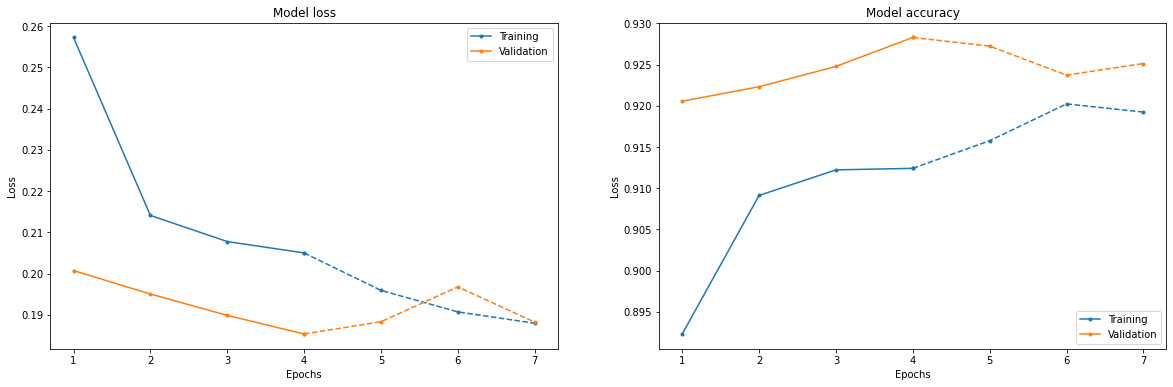

In [ ]:
resume_model_history(history_tune, early_stop)

In [ ]:
model_tune.save(drive_path + 'VGG_gender_tuned_2.h5')

##Test della rete 

In [ ]:
predictions = model_tune.predict(test_set_gender)

In [ ]:
y_test_gender = df_test['gender_label'].values
y_test_gender = y_test_gender.astype('float32')

Accuracy =  0.9278633199746888

Classification Report
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2572
           1       0.91      0.93      0.92      2169

    accuracy                           0.93      4741
   macro avg       0.93      0.93      0.93      4741
weighted avg       0.93      0.93      0.93      4741



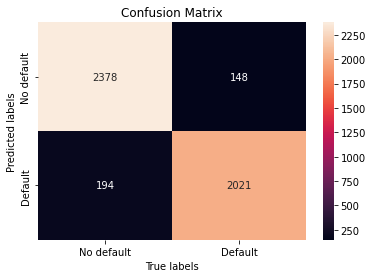

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns


Y_classes = (predictions > 0.5).astype(np.int8).argmax(axis=1) 

print('Accuracy = ', accuracy_score(Y_classes, y_test_gender))


print('\nClassification Report\n', classification_report(Y_classes, y_test_gender))


cm=confusion_matrix(y_test_gender, Y_classes)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No default', 'Default']); ax.yaxis.set_ticklabels(['No default', 'Default']);

# VGG-16 AGE

## Definizione e training della rete 

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, min_delta = 0, 
                           verbose=1, restore_best_weights=True) 


initializer = tf.keras.initializers.GlorotUniform(seed=1234)

num_classes = 2
input_shape = train_set_gender.image_shape

# Loading the VGG model
# base_vgg16_model = tf.keras.applications.VGG16(include_top=True, pooling='avg', weights="imagenet")

In [ ]:
# Architettura della rete VGG-Face
base_vggface_model = keras.Sequential()

base_vggface_model.add(layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
base_vggface_model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(128, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(256, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.ZeroPadding2D((1,1)))
base_vggface_model.add(layers.Convolution2D(512, (3, 3), activation='relu'))
base_vggface_model.add(layers.MaxPooling2D((2,2), strides=(2,2)))
 
base_vggface_model.add(layers.Convolution2D(4096, (7, 7), activation='relu'))
base_vggface_model.add(layers.Dropout(0.5))
base_vggface_model.add(layers.Convolution2D(4096, (1, 1), activation='relu'))
base_vggface_model.add(layers.Dropout(0.5))
base_vggface_model.add(layers.Convolution2D(2622, (1, 1)))
base_vggface_model.add(layers.Flatten())
base_vggface_model.add(layers.Activation('softmax'))

# Caricamento dei pesi pretrainati di VGG-Face
from keras.models import model_from_json
base_vggface_model.load_weights(drive_path + 'vgg_face_weights.h5')

In [ ]:
# Definizione dell'hypermodel per il tuning
def model_builder(hp):

  vgg16_model = Model(inputs=base_vggface_model.layers[0].input, outputs=base_vggface_model.layers[-2].output)
  

  model_vgg_age = keras.Sequential()
  
  # Blocking the weights of the previous layers
  for layer in vgg16_model.layers:
    layer.trainable = False
    model_vgg_age.add(layer)


  hp_dropout_conv = hp.Choice('dropout_conv', values = [0.0, 0.2, 0.5])
  if  hp_dropout_conv > 0:
    model_vgg_age.add(layers.Dropout(hp_dropout_conv, name='dropout_conv'))

  hp_num_dense = hp.Choice('num_dense_layers', values= [1, 2])
  hp_dense1_size = hp.Choice('first_dense_layer_size', values = [64, 128])
  model_vgg_age.add(layers.Dense(hp_dense1_size, activation='relu'))

  if hp_num_dense == 2:
    hp_dense2_size = hp.Choice('second_dense_layer_size', values = [32, 64, 128])
    model_vgg_age.add(layers.Dense(hp_dense1_size, activation='relu'))

  hp_dropout_dense = hp.Choice('dropout_dense', values = [0.0, 0.2, 0.5])
  if hp_dropout_dense > 0:
    model_vgg_age.add(layers.Dropout(hp_dropout_dense, name = 'dropout_dense'))


  # model_vgg_age.add(layers.Dense(2, activation='sigmoid'))

  model_vgg_age.add(layers.Dense(1, activation='relu'))

  
  optimizer = tf.keras.optimizers.get('adam')
  optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default = 1e-3)

  model_vgg_age.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mae'])

  # model_vgg_age.summary()

  return model_vgg_age


In [ ]:
# Inizializzazione del tuner
tuner = kt.BayesianOptimization(model_builder,
                                objective=kt.Objective('val_loss', direction="min"),
                                directory=drive_path+'keras_tuner',
                                max_trials = 10,
                              #  overwrite=True,
                                project_name='VGG_age_opt')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Visual_Progetto_VGG/keras_tuner/VGG_age_opt/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Visual_Progetto_VGG/keras_tuner/VGG_age_opt/tuner0.json


In [ ]:
# Tuning
tuner.search(train_set_age, epochs=50, validation_data = validation_set_age, shuffle = True,
             callbacks=[early_stop])

Trial 11 Complete [01h 19m 22s]
val_loss: 0.004380281548947096

Best val_loss So Far: 0.004380281548947096
Total elapsed time: 01h 19m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'dropout_conv': 0.5,
 'dropout_dense': 0.0,
 'first_dense_layer_size': 64,
 'learning_rate': 0.0001,
 'num_dense_layers': 2,
 'second_dense_layer_size': 128}

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_model.save(drive_path + 'vgg_age_tuned.h5')

In [ ]:
# visualizza a video alcune informazioni testuali di base sul training del modello
# e due grafici per analizzare l'andamento della loss e dell'accuracy durante il training
def resume_model_history_regression(history, early_stop = None):
  # estraggo il numero di epoche nel caso in cui l'early stopping è stato utilizzato
  if early_stop is not None:
    # verifico se l'early stop è entrato in funzione, se si prendo l'epoca in cui
    # si è fermato il training, altrimenti l'epoca migliore (corrisponderà al tot. max delle epoche)
    tot_epoch = early_stop.stopped_epoch+1 if (early_stop.stopped_epoch != 0) else early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  # senza early_stopping l'ultima epoca e la migliore coincidono
  else:
    tot_epoch = len(history.epoch)
    best_epoch = tot_epoch

  # visualizzo i risultati in forma testuale
  print("Numero di epoche totali:", tot_epoch)
  print("Epoca migliore (weights restored):", best_epoch)
  print("Accuracy training set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['mae'][best_epoch -1]))
  print("Accuracy validation set all'epoca " + str(best_epoch) + ': '
        + str(history.history['val_mae'][best_epoch -1]))
  print("Loss training set all'epoca " + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  print("Loss validation set all'epoca " + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][best_epoch -1]))
  
  print('\n\n')

  # visualizzo i grafici di loss e mae per training e validation
  fig = plt.figure(figsize =(20, 6))

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

  # stesso procedimento per l'accuracy
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model mae')
  # punti asse x
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  # visualizzo tutti i punti fino all'early stopping
  plt.plot(range(0,best_epoch,1), 
           history.history['mae'][:best_epoch], '.-', color="C0") # loss train
  plt.plot(range(0,best_epoch,1), 
           history.history['val_mae'][:best_epoch], '.-', color="C1") # loss val
  # visualizzo tutti i punti dopo l'early stopping in modo tratteggiato
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['mae'][best_epoch-1:], '.--', color="C0") # loss train
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_mae'][best_epoch-1:], '.--', color="C1") # loss val
  plt.legend(['Training', 'Validation'])

In [ ]:
# Training dell'architettura migliore per 50 epoche con EarlyStopping (pazienza=3)
model_tune = tuner.hypermodel.build(best_hps)
history_tune = model_tune.fit(train_set_age, epochs=50, validation_data = validation_set_age, 
                              shuffle = True,callbacks=[early_stop])

Epoch 1/50
126/126 [==============================] - 273s 2s/step - loss: 0.0288 - mae: 0.1260 - val_loss: 0.0135 - val_mae: 0.0900
Epoch 2/50
126/126 [==============================] - 170s 1s/step - loss: 0.0117 - mae: 0.0824 - val_loss: 0.0104 - val_mae: 0.0760
Epoch 3/50
126/126 [==============================] - 169s 1s/step - loss: 0.0097 - mae: 0.0727 - val_loss: 0.0088 - val_mae: 0.0675
Epoch 4/50
126/126 [==============================] - 169s 1s/step - loss: 0.0086 - mae: 0.0674 - val_loss: 0.0074 - val_mae: 0.0616
Epoch 5/50
126/126 [==============================] - 169s 1s/step - loss: 0.0078 - mae: 0.0637 - val_loss: 0.0073 - val_mae: 0.0612
Epoch 6/50
126/126 [==============================] - 170s 1s/step - loss: 0.0072 - mae: 0.0608 - val_loss: 0.0062 - val_mae: 0.0564
Epoch 7/50
126/126 [==============================] - 170s 1s/step - loss: 0.0070 - mae: 0.0600 - val_loss: 0.0061 - val_mae: 0.0552
Epoch 8/50
126/126 [==============================] - 170s 1s/step - 

Numero di epoche totali: 32
Epoca migliore (weights restored): 29
Accuracy training set all'epoca 29: 0.049886252731084824
Accuracy validation set all'epoca 29: 0.04642292112112045
Loss training set all'epoca 29: 0.00493632722645998
Loss validation set all'epoca 29: 0.004342643544077873





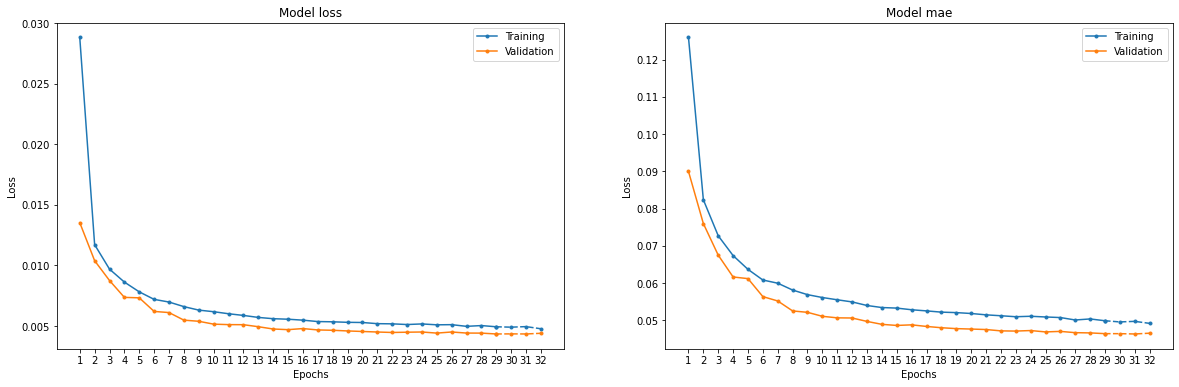

In [ ]:
resume_model_history_regression(history_tune, early_stop)

In [ ]:
model_tune.save(drive_path + 'vgg_age_tuned_2.h5')

## Test della rete

In [ ]:
model_vgg_age = keras.models.load_model(drive_path + 'vgg_age_tuned_2.h5')

In [ ]:
predictions = model_vgg_age.predict(test_set_age)

In [ ]:
y_test_age = df_test['age_label'].values
# y_test_age = y_test_age.astype('float32')

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test_age, predictions)

0.04577145638529409

In [ ]:
def top_k_accuracy(y_pred, y_true, k = 5):

  y_pred = scaler.inverse_transform(y_pred)
  y_true = scaler.inverse_transform(np.expand_dims(y_true, -1))

  total = len(y_pred)
  count = 0
  for idx, _ in enumerate(y_pred):
    if abs(y_pred[idx]-y_true[idx]) <= k:
      count += 1


  return round(100*count/total, 2)
 

print(f'Top-5 accuracy: {top_k_accuracy(predictions, y_test_age, 5)}')
print(f'Top-10 accuracy: {top_k_accuracy(predictions, y_test_age, 10)}')
print(f'Top-15 accuracy: {top_k_accuracy(predictions, y_test_age, 15)}')
print(f'Top-20 accuracy: {top_k_accuracy(predictions, y_test_age, 20)}')

Top-5 accuracy: 60.96
Top-10 accuracy: 85.47
Top-15 accuracy: 94.09
Top-20 accuracy: 97.81


# Fusione reti

In [ ]:
model_vgg_gender = keras.models.load_model(drive_path + 'VGG_gender_tuned_2.h5' )
model_vgg_age = keras.models.load_model(drive_path + 'vgg_age_tuned_2.h5')

In [ ]:
model_vgg_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                      

In [ ]:
model_vgg_age.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                      

In [ ]:
feature_extractor = Model(inputs=model_vgg_age.layers[0].input, outputs=model_vgg_age.get_layer('flatten').output)

feature_extractor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Input  [(None, 224, 224, 3)]    0         
 Layer)                                                          
                                                                 
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                           

In [ ]:
model_vgg_age_end = Model(inputs=model_vgg_age.get_layer('flatten').input, outputs=model_vgg_age.get_layer('dense_4').output)

vgg_age_end = keras.Sequential()

for idx, layer in enumerate(model_vgg_age_end.layers):
  if idx == 0:
    continue
  else:
    vgg_age_end.add(layer)

vgg_age_end.layers

In [ ]:
model_vgg_gender_end = Model(inputs=model_vgg_gender.get_layer('flatten').input, outputs=model_vgg_gender.get_layer('dense_5').output)

vgg_gender_end = keras.Sequential()

for idx, layer in enumerate(model_vgg_gender_end.layers):
  if idx == 0:
    continue
  else:
    vgg_gender_end.add(layer)


vgg_gender_end.layers

In [ ]:

x = layers.Input(shape = input_shape)
shared = feature_extractor(x)

out_gender = vgg_gender_end(shared)
out_age = vgg_age_end(shared)


model = Model(inputs=x, outputs=[out_gender, out_age])

In [ ]:
model.save(drive_path + 'model_merged.h5')

In [ ]:
# model = keras.models.load_model(drive_path + 'model_merged.h5')

# Prova con foto vere

In [ ]:
SCALER = 116

In [ ]:
gender_dict = {0: 'Uomo', 1: 'Donna'}

In [ ]:
model = keras.models.load_model(drive_path + 'model_merged.h5')

Prediction gender: [[9.9900645e-01 9.8873535e-04]] 
Genere predetto: Uomo 
Età predetta: [18 ; 28]
Elapsed time: 0.4757246971130371


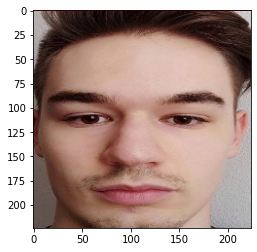

In [ ]:
import cv2
import matplotlib.pyplot as plt
import time

test_image = cv2.imread('detected_image.png')

test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = test_image.astype('float32')
test_image /= 255
test_image = cv2.resize(test_image, (224,224))

plt.imshow(test_image)

t_start = time.time()
prediction = model.predict(np.expand_dims(test_image, axis=0))
t_end = time.time()

prediction_gender = prediction[0]
prediction_age = prediction[1]

prediction_age = round(float(prediction_age*SCALER))
predicted_gender = np.argmax(prediction_gender)

print(f'Prediction gender: {prediction_gender} \nGenere predetto: {gender_dict[predicted_gender]} \nEtà predetta: [{prediction_age - 5} ; {prediction_age + 5}]')
print(f'Elapsed time: {t_end-t_start}')

In [ ]:
# Calcolo il tempo totale

start_time = time.time()

for im in test_set_age.next():
  _ = model.predict(im.reshape(1,224,224,3))

print("--- %s secondi necessari per predire una singola immagine! ---" % 
      round((time.time() - start_time)/test_set_age.batch_size, 3))

print(f'Batch size: {test_set_age.batch_size}')

--- 0.186 secondi necessari per predire una singola immagine! ---
Batch size: 128
